In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_test20_concate"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [15]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  

base_model1=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=MobileNetV2(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

merge = concatenate([x1, x2, x3])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
c1 = model.layers[7].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[53].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[141].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[481].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[827].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[835].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[851].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[866].output
c8 = GlobalAveragePooling2D()(c8) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [9]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [16]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 2s - loss: 0.6254 - acc: 0.6731 - val_loss: 0.5039 - val_acc: 0.7595
Epoch 2/1000
 - 1s - loss: 0.4855 - acc: 0.7693 - val_loss: 0.4953 - val_acc: 0.7489
Epoch 3/1000
 - 1s - loss: 0.4358 - acc: 0.7968 - val_loss: 0.3843 - val_acc: 0.8336
Epoch 4/1000
 - 1s - loss: 0.3910 - acc: 0.8216 - val_loss: 0.4135 - val_acc: 0.8069
Epoch 5/1000
 - 1s - loss: 0.3602 - acc: 0.8397 - val_loss: 0.3216 - val_acc: 0.8613
Epoch 6/1000
 - 1s - loss: 0.3332 - acc: 0.8512 - val_loss: 0.3400 - val_acc: 0.8529
Epoch 7/1000
 - 1s - loss: 0.3111 - acc: 0.8655 - val_loss: 0.3285 - val_acc: 0.8497
Epoch 8/1000
 - 1s - loss: 0.2877 - acc: 0.8748 - val_loss: 0.2605 - val_acc: 0.8887
Epoch 9/1000
 - 1s - loss: 0.2690 - acc: 0.8847 - val_loss: 0.2476 - val_acc: 0.9027
Epoch 10/1000
 - 1s - loss: 0.2523 - acc: 0.8926 - val_loss: 0.2660 - val_acc: 0.8852
Epoch 11/1000
 - 1s - loss: 0.2360 - acc: 0.9037 - val_loss: 0.2111 - val_acc: 0.9147
Epoch 12/1000
 

Epoch 96/1000
 - 1s - loss: 0.0204 - acc: 0.9932 - val_loss: 0.0143 - val_acc: 0.9954
Epoch 97/1000
 - 1s - loss: 0.0207 - acc: 0.9936 - val_loss: 0.0228 - val_acc: 0.9919
Epoch 98/1000
 - 1s - loss: 0.0226 - acc: 0.9925 - val_loss: 0.0138 - val_acc: 0.9968
Epoch 99/1000
 - 1s - loss: 0.0202 - acc: 0.9936 - val_loss: 0.0103 - val_acc: 0.9975
Epoch 100/1000
 - 1s - loss: 0.0196 - acc: 0.9936 - val_loss: 0.0103 - val_acc: 0.9968
Epoch 101/1000
 - 1s - loss: 0.0209 - acc: 0.9937 - val_loss: 0.0184 - val_acc: 0.9944
Epoch 102/1000
 - 1s - loss: 0.0196 - acc: 0.9936 - val_loss: 0.0115 - val_acc: 0.9961
Epoch 103/1000
 - 1s - loss: 0.0223 - acc: 0.9923 - val_loss: 0.0083 - val_acc: 0.9975
Epoch 104/1000
 - 1s - loss: 0.0186 - acc: 0.9938 - val_loss: 0.0074 - val_acc: 0.9979
Epoch 105/1000
 - 1s - loss: 0.0194 - acc: 0.9936 - val_loss: 0.0109 - val_acc: 0.9968
Epoch 106/1000
 - 1s - loss: 0.0194 - acc: 0.9926 - val_loss: 0.0064 - val_acc: 0.9986
Epoch 107/1000
 - 1s - loss: 0.0190 - acc: 0.99

Epoch 191/1000
 - 1s - loss: 0.0091 - acc: 0.9975 - val_loss: 0.0151 - val_acc: 0.9940
Epoch 192/1000
 - 1s - loss: 0.0098 - acc: 0.9964 - val_loss: 0.0039 - val_acc: 0.9989
Epoch 193/1000
 - 1s - loss: 0.0112 - acc: 0.9959 - val_loss: 0.0042 - val_acc: 0.9986
Epoch 194/1000
 - 1s - loss: 0.0109 - acc: 0.9961 - val_loss: 0.0041 - val_acc: 0.9982
Epoch 195/1000
 - 1s - loss: 0.0119 - acc: 0.9958 - val_loss: 0.0137 - val_acc: 0.9947
Epoch 196/1000
 - 1s - loss: 0.0088 - acc: 0.9965 - val_loss: 0.0033 - val_acc: 0.9989
Epoch 197/1000
 - 1s - loss: 0.0083 - acc: 0.9965 - val_loss: 0.0159 - val_acc: 0.9926
Epoch 198/1000
 - 1s - loss: 0.0097 - acc: 0.9966 - val_loss: 0.0020 - val_acc: 0.9993
Epoch 199/1000
 - 1s - loss: 0.0064 - acc: 0.9975 - val_loss: 0.0187 - val_acc: 0.9923
Epoch 200/1000
 - 1s - loss: 0.0086 - acc: 0.9972 - val_loss: 0.0045 - val_acc: 0.9982
Epoch 201/1000
 - 1s - loss: 0.0064 - acc: 0.9977 - val_loss: 0.0271 - val_acc: 0.9905
Epoch 202/1000
 - 1s - loss: 0.0112 - acc: 

 - 1s - loss: 0.0069 - acc: 0.9974 - val_loss: 0.0023 - val_acc: 0.9989
Epoch 286/1000
 - 1s - loss: 0.0064 - acc: 0.9977 - val_loss: 0.0067 - val_acc: 0.9982
Epoch 287/1000
 - 1s - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0097 - val_acc: 0.9954
Epoch 288/1000
 - 1s - loss: 0.0073 - acc: 0.9971 - val_loss: 0.0186 - val_acc: 0.9940
Epoch 289/1000
 - 1s - loss: 0.0073 - acc: 0.9974 - val_loss: 8.9794e-04 - val_acc: 0.9996
Epoch 290/1000
 - 1s - loss: 0.0072 - acc: 0.9974 - val_loss: 0.0036 - val_acc: 0.9989
Epoch 291/1000
 - 1s - loss: 0.0100 - acc: 0.9965 - val_loss: 0.0499 - val_acc: 0.9821
Epoch 292/1000
 - 1s - loss: 0.0066 - acc: 0.9980 - val_loss: 0.0026 - val_acc: 0.9986
Epoch 293/1000
 - 1s - loss: 0.0058 - acc: 0.9980 - val_loss: 0.0063 - val_acc: 0.9982
Epoch 294/1000
 - 1s - loss: 0.0061 - acc: 0.9974 - val_loss: 0.0053 - val_acc: 0.9972
Epoch 295/1000
 - 1s - loss: 0.0071 - acc: 0.9972 - val_loss: 0.0014 - val_acc: 0.9996
Epoch 296/1000
 - 1s - loss: 0.0054 - acc: 0.9984 - va

Epoch 379/1000
 - 1s - loss: 0.0059 - acc: 0.9986 - val_loss: 0.0033 - val_acc: 0.9986
Epoch 380/1000
 - 1s - loss: 0.0046 - acc: 0.9982 - val_loss: 0.0014 - val_acc: 0.9989
Epoch 381/1000
 - 1s - loss: 0.0053 - acc: 0.9981 - val_loss: 0.0029 - val_acc: 0.9993
Epoch 382/1000
 - 1s - loss: 0.0054 - acc: 0.9981 - val_loss: 0.0032 - val_acc: 0.9989
Epoch 383/1000
 - 1s - loss: 0.0041 - acc: 0.9984 - val_loss: 0.0012 - val_acc: 0.9996
Epoch 384/1000
 - 1s - loss: 0.0050 - acc: 0.9985 - val_loss: 0.0013 - val_acc: 0.9993
Epoch 385/1000
 - 1s - loss: 0.0046 - acc: 0.9989 - val_loss: 9.2599e-04 - val_acc: 0.9996
Epoch 386/1000
 - 1s - loss: 0.0034 - acc: 0.9988 - val_loss: 8.7246e-04 - val_acc: 0.9993
Epoch 387/1000
 - 1s - loss: 0.0054 - acc: 0.9984 - val_loss: 4.8985e-04 - val_acc: 1.0000
Epoch 388/1000
 - 1s - loss: 0.0052 - acc: 0.9975 - val_loss: 0.0011 - val_acc: 0.9993
Epoch 389/1000
 - 1s - loss: 0.0063 - acc: 0.9979 - val_loss: 0.0011 - val_acc: 0.9993
Epoch 390/1000
 - 1s - loss: 0.

Epoch 472/1000
 - 1s - loss: 0.0037 - acc: 0.9987 - val_loss: 0.0022 - val_acc: 0.9993
Epoch 473/1000
 - 1s - loss: 0.0052 - acc: 0.9986 - val_loss: 0.0039 - val_acc: 0.9982
Epoch 474/1000
 - 1s - loss: 0.0049 - acc: 0.9987 - val_loss: 5.8322e-04 - val_acc: 0.9996
Epoch 475/1000
 - 1s - loss: 0.0052 - acc: 0.9986 - val_loss: 6.3267e-04 - val_acc: 1.0000
Epoch 476/1000
 - 1s - loss: 0.0047 - acc: 0.9984 - val_loss: 0.0015 - val_acc: 0.9996
Epoch 477/1000
 - 1s - loss: 0.0052 - acc: 0.9984 - val_loss: 0.0263 - val_acc: 0.9923
Epoch 478/1000
 - 1s - loss: 0.0063 - acc: 0.9975 - val_loss: 0.0014 - val_acc: 0.9996
Epoch 479/1000
 - 1s - loss: 0.0049 - acc: 0.9982 - val_loss: 3.0570e-04 - val_acc: 1.0000
Epoch 480/1000
 - 1s - loss: 0.0026 - acc: 0.9987 - val_loss: 0.0013 - val_acc: 0.9993
Epoch 481/1000
 - 1s - loss: 0.0044 - acc: 0.9984 - val_loss: 0.0020 - val_acc: 0.9989
Epoch 482/1000
 - 1s - loss: 0.0047 - acc: 0.9986 - val_loss: 0.0019 - val_acc: 0.9993
Epoch 483/1000
 - 1s - loss: 0.

Epoch 565/1000
 - 1s - loss: 0.0058 - acc: 0.9981 - val_loss: 0.0010 - val_acc: 0.9993
Epoch 566/1000
 - 1s - loss: 0.0035 - acc: 0.9989 - val_loss: 7.8549e-04 - val_acc: 0.9996
Epoch 567/1000
 - 1s - loss: 0.0031 - acc: 0.9988 - val_loss: 0.0043 - val_acc: 0.9982
Epoch 568/1000
 - 1s - loss: 0.0037 - acc: 0.9987 - val_loss: 1.0473e-04 - val_acc: 1.0000
Epoch 569/1000
 - 1s - loss: 0.0052 - acc: 0.9985 - val_loss: 5.1143e-04 - val_acc: 1.0000
Epoch 570/1000
 - 1s - loss: 0.0044 - acc: 0.9988 - val_loss: 0.0083 - val_acc: 0.9972
Epoch 571/1000
 - 1s - loss: 0.0030 - acc: 0.9992 - val_loss: 0.0043 - val_acc: 0.9982
Epoch 572/1000
 - 1s - loss: 0.0025 - acc: 0.9992 - val_loss: 2.0535e-04 - val_acc: 1.0000
Epoch 573/1000
 - 1s - loss: 0.0035 - acc: 0.9986 - val_loss: 1.4144e-04 - val_acc: 1.0000
Epoch 574/1000
 - 1s - loss: 0.0055 - acc: 0.9981 - val_loss: 5.7234e-04 - val_acc: 0.9996
Epoch 575/1000
 - 1s - loss: 0.0036 - acc: 0.9991 - val_loss: 0.0011 - val_acc: 0.9996
Epoch 576/1000
 - 1

Epoch 658/1000
 - 1s - loss: 0.0030 - acc: 0.9988 - val_loss: 4.2474e-04 - val_acc: 1.0000
Epoch 659/1000
 - 1s - loss: 0.0017 - acc: 0.9993 - val_loss: 6.5000e-05 - val_acc: 1.0000
Epoch 660/1000
 - 1s - loss: 0.0060 - acc: 0.9984 - val_loss: 0.0206 - val_acc: 0.9944
Epoch 661/1000
 - 1s - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0013 - val_acc: 0.9993
Epoch 662/1000
 - 1s - loss: 0.0015 - acc: 0.9992 - val_loss: 5.2110e-04 - val_acc: 1.0000
Epoch 663/1000
 - 1s - loss: 0.0045 - acc: 0.9989 - val_loss: 0.0035 - val_acc: 0.9989
Epoch 664/1000
 - 1s - loss: 0.0016 - acc: 0.9993 - val_loss: 0.0017 - val_acc: 0.9989
Epoch 665/1000
 - 1s - loss: 0.0035 - acc: 0.9985 - val_loss: 2.0727e-04 - val_acc: 1.0000
Epoch 666/1000
 - 1s - loss: 0.0029 - acc: 0.9993 - val_loss: 2.6661e-04 - val_acc: 1.0000
Epoch 667/1000
 - 1s - loss: 0.0057 - acc: 0.9985 - val_loss: 4.8785e-04 - val_acc: 1.0000
Epoch 668/1000
 - 1s - loss: 0.0046 - acc: 0.9984 - val_loss: 5.2822e-04 - val_acc: 0.9996
Epoch 669/1000


Epoch 750/1000
 - 1s - loss: 0.0024 - acc: 0.9991 - val_loss: 0.0020 - val_acc: 0.9993
Epoch 751/1000
 - 1s - loss: 0.0015 - acc: 0.9994 - val_loss: 0.0012 - val_acc: 0.9993
Epoch 752/1000
 - 1s - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0020 - val_acc: 0.9996
Epoch 753/1000
 - 1s - loss: 0.0045 - acc: 0.9991 - val_loss: 2.2359e-04 - val_acc: 1.0000
Epoch 754/1000
 - 1s - loss: 0.0036 - acc: 0.9989 - val_loss: 5.7259e-04 - val_acc: 1.0000
Epoch 755/1000
 - 1s - loss: 0.0059 - acc: 0.9985 - val_loss: 7.3033e-05 - val_acc: 1.0000
Epoch 756/1000
 - 1s - loss: 0.0044 - acc: 0.9987 - val_loss: 1.4782e-04 - val_acc: 1.0000
Epoch 757/1000
 - 1s - loss: 0.0022 - acc: 0.9992 - val_loss: 0.0046 - val_acc: 0.9979
Epoch 758/1000
 - 1s - loss: 0.0022 - acc: 0.9989 - val_loss: 3.7387e-04 - val_acc: 1.0000
Epoch 759/1000
 - 1s - loss: 0.0025 - acc: 0.9991 - val_loss: 0.0012 - val_acc: 0.9996
Epoch 760/1000
 - 1s - loss: 0.0020 - acc: 0.9991 - val_loss: 0.0021 - val_acc: 0.9989
Epoch 761/1000
 - 1s - 

Epoch 842/1000
 - 1s - loss: 0.0034 - acc: 0.9992 - val_loss: 2.8988e-04 - val_acc: 1.0000
Epoch 843/1000
 - 1s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0044 - val_acc: 0.9982
Epoch 844/1000
 - 1s - loss: 0.0040 - acc: 0.9988 - val_loss: 3.8487e-04 - val_acc: 1.0000
Epoch 845/1000
 - 1s - loss: 0.0025 - acc: 0.9989 - val_loss: 2.2641e-04 - val_acc: 1.0000
Epoch 846/1000
 - 1s - loss: 0.0023 - acc: 0.9991 - val_loss: 5.8754e-04 - val_acc: 0.9996
Epoch 847/1000
 - 1s - loss: 0.0024 - acc: 0.9994 - val_loss: 8.5310e-05 - val_acc: 1.0000
Epoch 848/1000
 - 1s - loss: 6.5798e-04 - acc: 0.9996 - val_loss: 0.0040 - val_acc: 0.9986
Epoch 849/1000
 - 1s - loss: 0.0028 - acc: 0.9992 - val_loss: 4.9624e-04 - val_acc: 1.0000
Epoch 850/1000
 - 1s - loss: 0.0021 - acc: 0.9993 - val_loss: 6.0491e-05 - val_acc: 1.0000
Epoch 851/1000
 - 1s - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0017 - val_acc: 0.9993
Epoch 852/1000
 - 1s - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0043 - val_acc: 0.9982
Epoch 853/1

Epoch 934/1000
 - 1s - loss: 0.0034 - acc: 0.9987 - val_loss: 4.6506e-05 - val_acc: 1.0000
Epoch 935/1000
 - 1s - loss: 0.0012 - acc: 0.9995 - val_loss: 5.3728e-04 - val_acc: 0.9996
Epoch 936/1000
 - 1s - loss: 0.0033 - acc: 0.9989 - val_loss: 3.0473e-05 - val_acc: 1.0000
Epoch 937/1000
 - 1s - loss: 0.0038 - acc: 0.9989 - val_loss: 0.0012 - val_acc: 0.9996
Epoch 938/1000
 - 1s - loss: 0.0046 - acc: 0.9985 - val_loss: 2.2676e-04 - val_acc: 1.0000
Epoch 939/1000
 - 1s - loss: 0.0050 - acc: 0.9988 - val_loss: 2.1120e-04 - val_acc: 1.0000
Epoch 940/1000
 - 1s - loss: 0.0018 - acc: 0.9994 - val_loss: 8.6423e-04 - val_acc: 0.9996
Epoch 941/1000
 - 1s - loss: 0.0034 - acc: 0.9992 - val_loss: 0.0024 - val_acc: 0.9989
Epoch 942/1000
 - 1s - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0029 - val_acc: 0.9996
Epoch 943/1000
 - 1s - loss: 0.0035 - acc: 0.9988 - val_loss: 4.4869e-05 - val_acc: 1.0000
Epoch 944/1000
 - 1s - loss: 0.0038 - acc: 0.9988 - val_loss: 5.7483e-04 - val_acc: 1.0000
Epoch 945/1

In [17]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8309859154929577


Confusion Matrix
[[34  2]
 [10 25]]


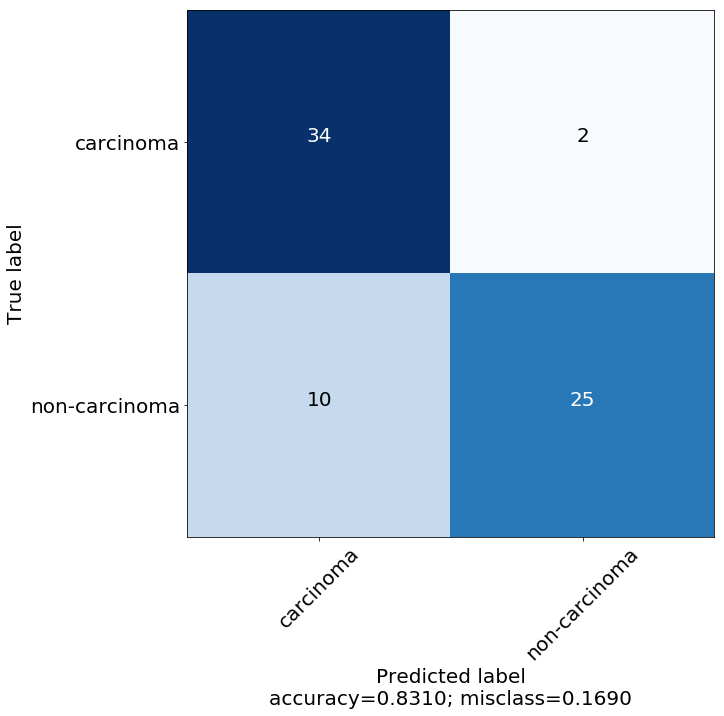

In [18]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[34  2]
 [10 25]]
               precision    recall  f1-score   support

non-carcinoma       0.77      0.94      0.85        36
    carcinoma       0.93      0.71      0.81        35

    micro avg       0.83      0.83      0.83        71
    macro avg       0.85      0.83      0.83        71
 weighted avg       0.85      0.83      0.83        71



In [20]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  77.27272727272727
Specificity :  92.5925925925926


In [21]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8493265993265994


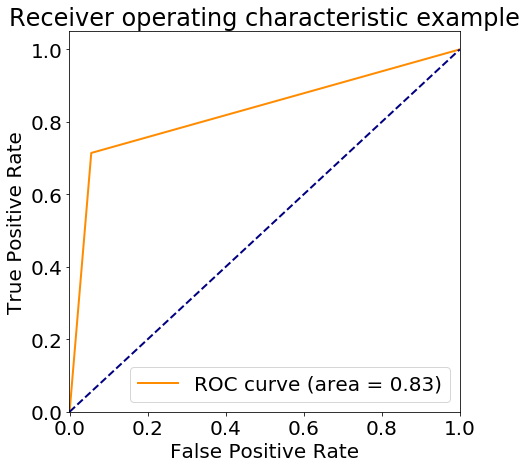

In [22]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [23]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 98us/step


In [24]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [25]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

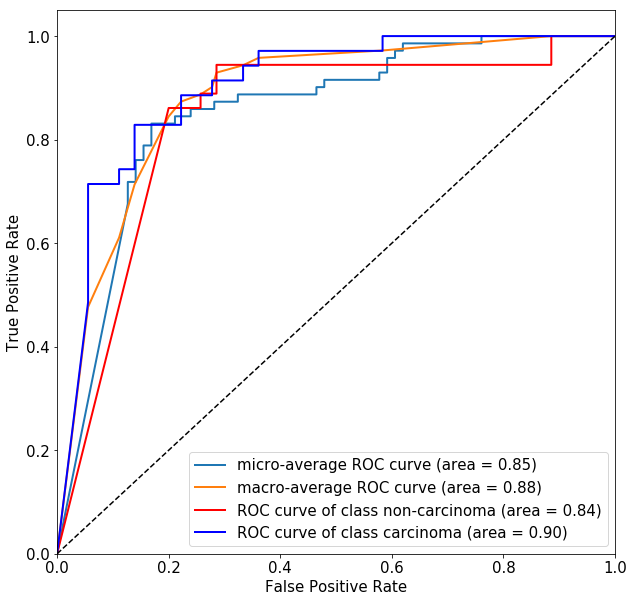

In [26]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [27]:
tn, fp, fn, tp = cm.ravel()

In [28]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8309859154929577
Precision: 0.9259259259259259
Recall: 0.7142857142857143
tp: 25
fp: 2
tn: 34
fn: 10


In [29]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8064516129032259


In [30]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8064516129032259


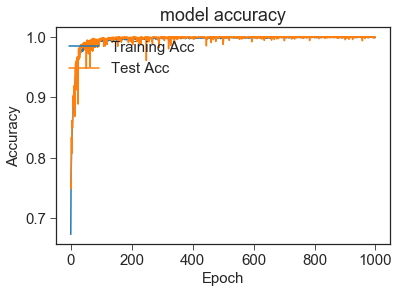

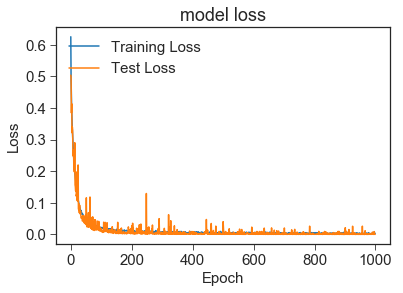

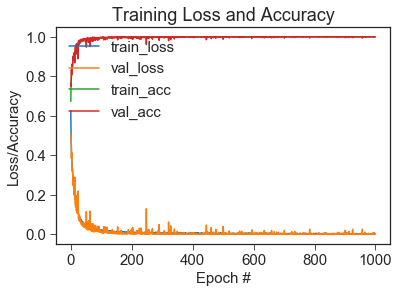

In [31]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")